In [1]:
# REDACT
import numpy as np
import matplotlib.pyplot as plt
import numpyro
from chainconsumer import ChainConsumer
import pandas as pd


# The Importance of Importance Sampling

If you've spent more than a few minutes working in Bayesian numerical statistics, you've probably run across [**importance sampling**](https://en/wikipedia.org/importance_sampling), the ugly ducking of Bayesian methods. The idea behind importance sampling is to take sample from one distribution (usually the output of something like an MCMC sampler) and, using sample weights, nudge them in a way that lets us re-use them as though they were from a _different_ but _similar_ distribution.

**An Overly General Derivation**

A common problem in statistics is wanting to know the average value of some property over some **target distribution**, i.e. finding some expected value:

$$
E_T \left[ f(\theta) \right]=\int f(\theta) P_T(\theta) d\theta
$$

This might seem a bit abstract, but as we'll see later this covers a lot of use cases. If you have some set of $I$ samples drawn from the target distribution $\{ \theta_i \} \sim P_T(\theta)$ (e.g. from MCMC), then this expected value can be found easily by averaging over the samples:

$$
E_T \left[ f(\theta) \right] = \frac{1}{I} \sum_i f(\theta_i)
$$

But what if we _don't_ have those samples, and instead have them drawn from a similar but distinct **sampling distribution**, $\{ \theta_i \} \sim P_S(\theta)$. This is where importance sampling comes in: we can easily express that integral over the sampling distribution:

$$
\int f(\theta) P_T(\theta) d\theta = \int f(\theta) \frac{P_T(\theta)}{P_S(\theta)} P_S(\theta) d\theta = E_S \left[ f(\theta) \frac{P_T(\theta)}{P_S(\theta)} \right]
$$

Meaning we can get an average over the target distribution with a weighted sum over the sampling distribution:

$$
E_S \left[ f(\theta)\frac{P_T(\theta)}{P_S(\theta)} \right] =  \frac{1}{I} \sum_i{ \frac{P_T(\theta_i)}{P_S(\theta_i)} f(\theta_i)}
$$

You'll notice that this is functionally the same as taking weighted redraws of out samples with weights $w_i=\frac{P_T(\theta_i)}{P_S(\theta_i)}$.



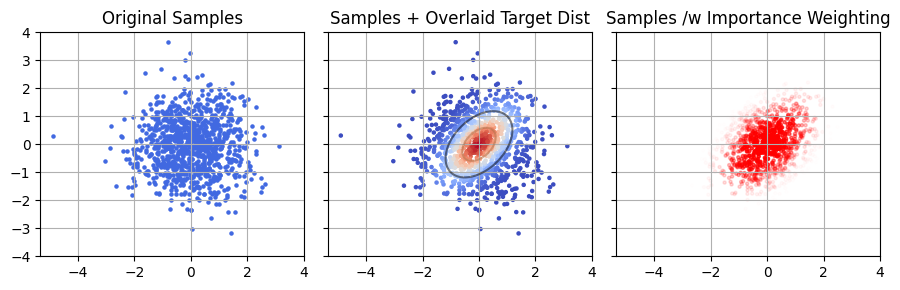

In [2]:
# REDACT
N = 1_000
pos = np.random.multivariate_normal(mean=[0,0], cov = np.eye(2), size=N)

Xs, Ys = pos.T
r1,r2  = .25, .1
cov2 = np.array([[r1+r2,r1-r2],[r1-r2,r1+r2]])
cov2i = np.linalg.inv(cov2)

Xtest,Ytest = np.random.multivariate_normal(mean=[0,0], cov = cov2, size=N).T

P1 = np.exp(-1/2*(Xs**2+Ys**2)) / np.sqrt(2*np.pi)
p1  = lambda X,Y: np.exp(-0.5*(X**2 * cov2i[0,0] + Y**2) )
p2  = lambda X,Y: np.exp(-0.5*(X**2 * cov2i[0,0] + Y**2 * cov2i[1,1] + X*Y * (cov2i[1,0] + cov2i[0,1])))
P2 = p2(Xs,Ys)

# Make Contours
Xgrid,Ygrid = np.meshgrid(*[np.linspace(-4,4,256)]*2)
Pgrid = p2(Xgrid,Ygrid)
R = P2/P1
W = R/R.sum()

I = np.random.choice(range(N), N, replace=True, p=W)

#------------------------------
fig, axs = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
a1,a2,a3 = axs
a1.scatter(Xs, Ys, s = 5, c='royalblue')
a2.scatter(Xs, Ys, s = 5, c = R, cmap = 'coolwarm')
a2.contour(Xgrid, Ygrid, Pgrid, levels = [np.exp(-i**2/2) for i in range(3)][::-1], alpha=0.5, cmap = 'copper')
a3.scatter(Xs, Ys, s = 5, c = 'red', alpha = W/W.max())

for ax in axs: ax.grid()

a1.set_title('Original Samples')
a2.set_title('Samples + Overlaid Target Dist')
a3.set_title('Samples /w Importance Weighting')

plt.tight_layout()
plt.show()

In most contexts, importance sampling is used to describe cases where our samples are drawn in some stochastic way, e.g. them being the output of some MCMC or nested sampling run on a similar problem. In these cases, the sampling density is the posterior density normalized by the model evidence, i.e. if our sampling distribution is the posterior for model $S$ fitting some data $d$ then:

$$
P_S(\theta) = \frac{1}{Z_S(d)} \mathcal{L}(\theta\vert d,S) \times \pi(\theta \vert S)
$$

I discuss this more at the end of this article, but the same reasoning can be applied in a much broader sense. Prior sampling, nested sampling, and any number of other methods can all be described as various flavours of importance sampling.

**But Why Not Just Take Weighted Samples?**

Given importance sampling is conceptually analagous to weighted re-draws, you might find yourself asking "why bother?" The answer is down to sample size - anything we do to recycle existing samples is necessarily going to result in a _smaller_ final chain of sample, and we want to keep this loss rate as low as possible. For weighted redraws, our new sample size is just the number of unique samples that we've retained. For importance sampling, we can make use of an estimator outlined in [this paper](https://arxiv.org/pdf/1602.03572), which gives an effective sample size (ESS) of:  

$$
\mathrm{ESS}_\mathrm{Imp. Samp.} = \frac{\left( \sum_{i}{w_i} \right)^2}{\sum_{i}{w_i^2}}
$$

If we do this for our example above, we find that full importance sampling gives us a markedly higher sample size than weighted redraws (see the figure below). The reason is pretty intuitive: re-drawing necessarily throws away all our low-density samples. Individually these aren't interesting, but in aggregate those low weight samples stack up to a significant amount of the domain. In importance sampling, we keep track of every sample site we can. This low weight "shell" mightn't be that big In this 2D example, but it's easy to imagine how it might grow to form the lion's share of the samples in higher dimensions or in distributions with long tails.

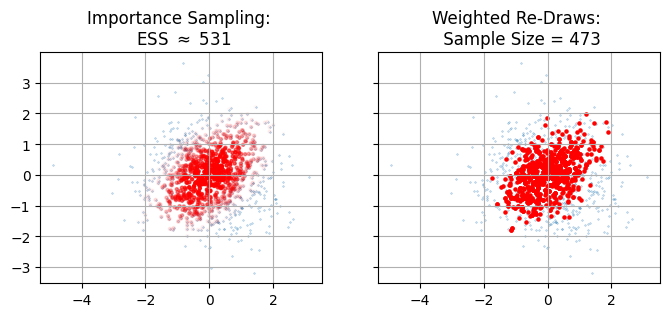

In [3]:
# REDACT
fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
axs[0].scatter(Xs, Ys, s = 5, c = 'red', alpha = W/W.max())
axs[1].scatter(Xs[I], Ys[I], s = 5, c = 'red')
for ax in axs:
    ax.scatter(Xs, Ys, s = 1, c = 'tab:blue', zorder=-1, marker='x', alpha=0.25)
    ax.grid()

w = W/W.max()
ESS = (w.sum())**2 / (w**2).sum()
axs[0].set_title("Importance Sampling: \n ESS $\\approx$ %i" %ESS)
axs[1].set_title("Weighted Re-Draws: \n Sample Size = %i" %np.unique(I).size)
plt.show()

## Evidences from Importance Sampling

Up to now, I've talked about importance sampling to get "integrals" in the general sense, but this is a bit vague. Let's look at maybe the most common integral we come across in Bayes work: the [model evidence](https://en.wikipedia.org/wiki/Marginal_likelihood) (or more generally, marginal probability). For some model $M$ with parameters $\theta$, the evidence is the total ability of the model to explain some observed data $d$:

$$
Z_M = \int \mathcal{L}(d \vert \theta,M) \pi(\theta \vert M) d\theta
$$

Doing our importance sampling trick, we can turn this into an expected value over our sampling distribution $S$:

$$
Z_M = \int \frac{\mathcal{L}(d \vert \theta,M) \pi(\theta \vert M) }{P_S(\theta)} P(\theta)d\theta = E_S \left[\frac{\rho_m(\theta)}{P_s(\theta)} \right]
$$

I've wrapped the whole numerator up in a single _non_-normalized "mass density" $\rho_M(\theta)$, and we'll see why in a moment. Assuming we know the density for $P_S(\theta)$ and can draw samples from it, this is again a nice tidy discrete summation:

$$
Z_m \approx \sum_i \frac{\rho_m(\theta)}{P_s(\theta)},\ \ \{\theta_i\} \sim P_s(\theta)
$$

Let's take a beat and think about what this actually means. Every sample $\theta_i$ "owns" a region of parameter space with volume $\Delta V_i = 1/P_s(\theta)$, i.e. "one sample per volume $\Delta V_i$. Thinking in this way, the summation looks a lot more like the familiar idea of evidence being the "probability mass" to $\rho_M$'s "probability density":

$$
Z_m \approx \sum_i \rho_m(\theta) \Delta V_i
$$

Thinking of things in this way, as a discrete sum of chunks of integral "stuff", makes its a lot easier to intuit how importance sampling works and whether or not it's going to be stable.


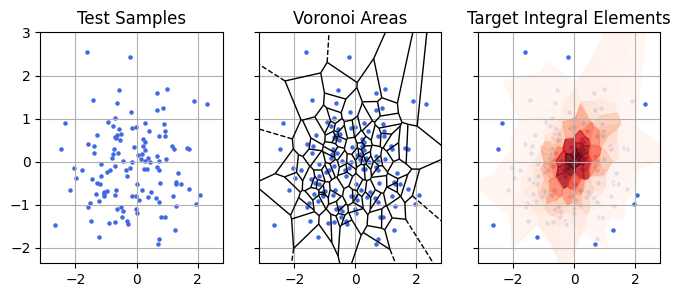

In [4]:
# REDACT

import matplotlib as mpl
import matplotlib.cm as cm
from scipy.spatial import Voronoi, voronoi_plot_2d


fig, axs = plt.subplots(1,3, figsize=(8,3), sharex=True, sharey=True)
a1,a2,a3 = axs

sparse=8

for a in a1,a2,a3: a.scatter(Xs[::sparse], Ys[::sparse], s = 5, c = 'royalblue', zorder=-np.inf)
for ax in axs:
    ax.grid()

V = Voronoi(np.vstack([Xs[::sparse], Ys[::sparse]]).T)

# find min/max values for normalization
C = P2.copy()[::sparse]
minima = min(C)
maxima = max(C)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)

voronoi_plot_2d(V, show_vertices = False, show_points = False, ax=a2)
for r in range(len(V.point_region)):
    region = V.regions[V.point_region[r]]
    if not -1 in region:
        polygon = [V.vertices[i] for i in region]
        a3.fill(*zip(*polygon), color=mapper.to_rgba(C[r]), alpha=0.85)


a1.set_title("Test Samples")
a2.set_title("Voronoi Areas")
a3.set_title("Target Integral Elements")
plt.show()

In the plot above, I re-do the importance sampling example from earlier but thinning the samples for the sake of visual clarity. Starting with points from our sample distribution (left), importance sampling is conceptually analagous to assigning each of those points a chunk of volume that it owns (shown in the voronoi diagram, middle panel). We then estimate the total "mass" (evidence) of the target distribution by estimating the density of those chunks (red) in the target distribution and adding them together.

**A Simple But Motivated Example - Recycling Posterior Chains for Changing Priors**

This can all seem a little abstract, but there's a simple motivated case example: changing priors without having to run an expensive MCMC run. Consider Gravitational Wave (GW) science, where we get a waveform describing how a particular GW event distorts space as it passes over our detectors. Programs like [`bilby`](https://bilby-dev.github.io/bilby/) take these waveforms and do an expensive Bayesian fit for an entire _fifteen_ model parameters, an endeavour that can take multiple days on a computer cluster. These fits usually assume the vaguest possible priors to avoid confirmation bias, but we have plenty of physically motivated priors for things like the mass, spin alignment etc of the colliding objects that produced the wave.

In strict Bayesian nonclemature, changing between two sets of priors means that you are changing between two different models. We have a "null" model with vague priors, $\varnothing$, and a physics model with informative priors, $M$. In both models the likelihood is the same for some data $d$, i.e.:

$$
\mathcal{L}(d \vert \theta , \varnothing) = \mathcal{L}(d \vert \theta , M) = \mathcal{L}(d \vert \theta)
$$

Our target distribution is the posterior with the informative priors:

$$
P_T(\theta) = \pi(\theta \vert M) \mathcal{L}(d \vert \theta)
$$

While our sampling distribution is the posterior with the null priors:

$$
P_S(\theta) = \pi(\theta \vert \varnothing) \mathcal{L}(d \vert \theta)
$$

So the sampling ratio is just the ratio of the priors:

$$
\frac{P_T(\theta)}{P_S(\theta)} = \frac{\pi(\theta \vert M)}{\pi(\theta \vert \varnothing)}
$$

Meaning we could get $\theta \sim P(\theta \vert d,M)$ by doing a weighted redraw of $\theta \sim P(\theta \vert d,\varnothing)$. In GW circles this is called _recycling_ of the posterior chains. The motivation here is that fitting the posterior chains is expensive and time consuming, and we'd rather not burn all that CPU time to slightly nudge our priors. Importance sampling shines here because it lets us re-shape our samples without needing to re-do the onerous likelihood calculations and without needing to tangle with the difficult task of finding contours in high dimensions, as the heavy lifting was already done in the initial fit to $\varnothing$.



In [5]:
# REDACT
# Generate Samples from a prior
prior_mu, prior_sig = 0.0, 2.0
Nsamp = 10_000
Xs = np.random.randn(Nsamp)*prior_sig + prior_mu

prior_old = lambda x: np.exp(-((x-prior_mu)/prior_sig)**2/2)
prior_new = lambda x: np.exp(-(x*2)**2/2) * (0.25 + (5*x)**2 )
likelihood = lambda x: 1/(1+(x*2)**2)

# Use weighted redraws to get posterior samples
wl = likelihood(Xs)
wl/=wl.sum()
Xs = np.random.choice(Xs, Nsamp, p=wl, replace=True)

In [6]:
# Importance sample with prior sampling to get posterior samples with _new_ prior
w = prior_new(Xs) / prior_old(Xs)
w/=w.sum()
Xt = np.random.choice(Xs, Nsamp, p=w, replace=True)

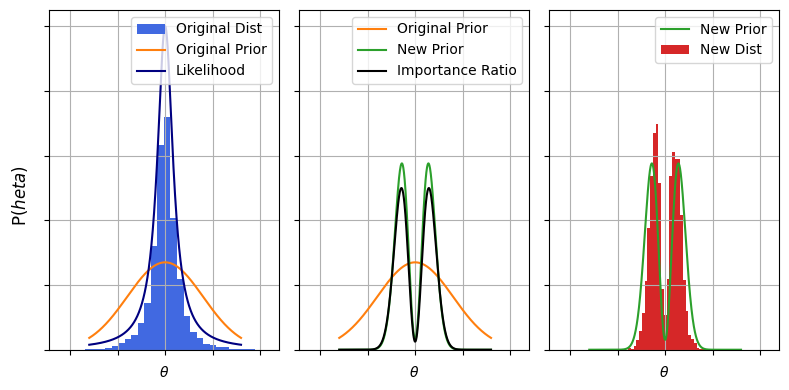

In [7]:
# REDACT
Xgrid  = np.linspace(-4,4,1024)
Xs = Xs[Xs.argsort()]
R = prior_new(Xs) / prior_old(Xs)

nbin = 32
fig, [a1, a2, a3] = plt.subplots(1,3,sharex=True, sharey=True, figsize=(8,4))
a1.hist(Xs, bins=nbin, density=True, label = "Original Dist", color = 'royalblue')

for a in [a1,a2]:
    a.plot(Xgrid, prior_old(Xgrid) / np.trapezoid(Xgrid, prior_old(Xgrid)) * -1 , label = "Original Prior", color = 'tab:orange')
for a in [a2,a3]:
    a.plot(Xgrid, prior_new(Xgrid) / np.trapezoid(Xgrid, prior_new(Xgrid)) * -1 , label = "New Prior", color = 'tab:green')
a2.plot(Xgrid, prior_new(Xgrid) / prior_old(Xgrid) / 10, label = 'Importance Ratio', color = 'black')

a3.hist(Xt, bins=nbin, density=True, color = 'tab:red', label = 'New Dist')
for a in [a1,a2,a3]: 
    if a is not a2 and a is not a3: a.plot(Xgrid,likelihood(Xgrid),color='navy',label='Likelihood')
    a.grid()
    a.legend(loc='upper right')
    a.set_yticklabels([]),    a.set_xticklabels([])
    a.set_xlabel("$\\theta$")
fig.supylabel("P($\theta$)")
fig.tight_layout()

plt.show()


**A More Realistic Example - Hierarchical Models**  
If we're being realistic, slightly altering out priors is probably not the best justified case for using importance sampling. If we can run a sampler once, we can probably run it twice. However we might _not_ be able to justify running it _hundreds_ of times if we, for the sake of argument, wanted to trial many different priors. Similarly, the cost of re-running samplers rapidly blows out if we need to do it for many many sources, and the problem compounds if we need to do both at once. Of course, we have a name for trialling many different types of prior with many sources simultaneously: we call it a _hierarchical model_. 

Let's consider a practical example: my home turf of [AGN reverberation mapping](https://arxiv.org/abs/2105.06926)(RM). In RM we measure a lag $\Delta t$ between two signals from a distant quasar, and use this echo RM to measure how large the system is. RM is a fiddly problem (see [my paper](https://arxiv.org/abs/2505.09832) on the difficulties if you're interested) but numerically definitely in the "low dimension" scale: including the lag we only need to fit about $6$ parameters. When fitting lags, we usually adopt a generously vague prior over $\Delta t$, but we also know that there's a scaling relationship between the lag and the luminosity of the quasar, a power-law "Radius-Luminosity" (R-L) relationship, which is a necessarily more informative prior. If we're doing thing's properly, we would want to fit both the slope, offset and spread of the R-L relationship at the same time as a giant set of lags, i.e. we'd want to fit a _hierarchical model_. 

In hierarchical models, every event $j$ is fit to a prior $\pi(\theta_j \vert \Lambda)$, where $\Lambda$ are the parameters that describe the prior itself:

$$
\pi(\theta \vert \varnothing) \rightarrow \pi(\Lambda \vert M) \pi(\theta \vert \Lambda)
$$

We fit for $\{\theta_j\}$ _at the same time_ as $\Lambda$. Assuming each source $j$ is uncorrelated, the marginal likelihood (i.e. 'goodness of fit') for a particular population model is:

$$
\mathcal{L}(\Lambda \vert d) 
= P(\Lambda) \prod_j \left( {\int P(\theta_k \vert d_j) d\theta_j} \right)
= P(\Lambda) \prod_j \frac{1}{Z(d_j)} \left( {\int \mathcal{L}(d_j \vert \theta_j) \pi (\theta_j \vert \Lambda ) d\theta_j} \right)
$$

The problem here is simple: if we have a few dozen RM sources and a half dozen parameters each, we very quickly climb into the $100$'s of parameters, making this numerically _extremely_ difficult. This is where importance sampling can show its value: we can break the fitting down into two steps: first, fitting each source with vague priors, and then _re-cycling_ those samples to do a true hierarchical fit:

$$
\mathcal{L}(\Lambda \vert d) =
\prod_j \frac{1}{Z(d_j)} \left( {\int \mathcal{L}(\theta_j \vert d_j) \frac{\pi (\theta_j \vert \Lambda )}{\pi (\theta_j \vert \varnothing)} \times \pi (\theta_j \vert \varnothing) d\theta_j} \right)
\propto \prod_j E_{\theta_j \sim P(\theta_j \vert d_j,\varnothing)} \left[ {\frac{\pi (\theta_j \vert \Lambda )}{\pi (\theta_j \vert \varnothing)} } \right]
$$

Or, for some discrete chain of samples:

$$
\mathcal{L}(\Lambda \vert d) 
\approx 
 \prod_j\frac{1}{I} \sum_i  {\frac{\pi (\theta_j^i \vert \Lambda )}{\pi (\theta_j^i \vert \varnothing)} }
, \;\;
\{ \theta_j^i\}  \sim P(\theta_j \vert d_j,\varnothing)
$$

In the above, we'd ended up with an approximate form for $\mathcal{L}(d \vert \Lambda)$ that only requires basic operations (multiplication, addition, etc), but more importantly we've reduced the degrees of freedom we need to explore to the dimensionality of $\Lambda$. Essentially, we've used our vague fits of $P(\theta_j \vert d_j, \varnothing)$ to marginalize over the individual source parameters. In the RM example, this reduces our free dimensions from hundreds to a breazy $3$.


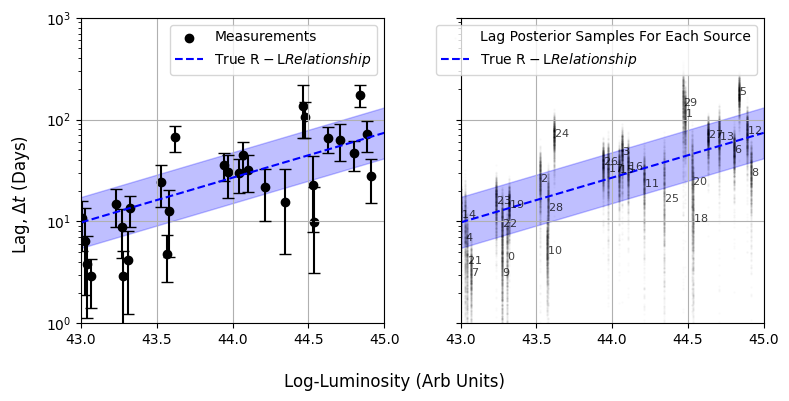

In [8]:
# REDACT

# Fake Some Data
np.random.seed(12)
Nlags = 30
alpha, beta, sigma, offset = 0.44, 1.43, 0.25, 44
loglum_min, loglum_max = 43, 45
loglums = np.random.rand(Nlags)*(loglum_max -loglum_min) + loglum_min

loglags_true = (loglums-offset) * alpha + beta + np.random.randn(Nlags) * sigma
lags_true = 10**loglags_true


lag_err_flat = 30
lag_err_prop = 0.3
lag_err_prop_max = 0.5
lag_err = [min( (lag_err_flat/l + lag_err_prop), lag_err_prop_max) * l for l in lags_true]
lags_obs = lags_true + np.random.randn(Nlags)*lag_err

#---------------------

Nsamps = 1_000
samples = [
    abs(lag + np.random.randn(Nsamps) * sig) for lag,sig in zip(lags_obs, lag_err)
          ]


#---------------------
# Plotting
lumplot = np.linspace(loglum_min, loglum_max, 1024)
lagplot = np.power(10, (lumplot-offset) * alpha + beta)

plotlag = [np.median(samps) for samps in samples]
Emin, Eplus = [[abs(np.percentile(samps,p) - np.median(samps)) for samps in samples] for p in (16,84)]

fig, (a1,a2) = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
plt.yscale('log')
a1.errorbar(loglums, plotlag, [Emin, Eplus], fmt='none', capsize = 4, c='k')
a1.scatter(loglums, plotlag, c='k', label = "Measurements")



for i, (loglum, samps) in enumerate(zip(loglums,samples)):
    a2.scatter(np.ones_like(samps)*loglum, samps, c='k', alpha=0.01, s=1, label = "Lag Posterior Samples For Each Source" if i==1 else None)
    a2.text(loglum, np.median(samps), "$%i$" %i, fontsize = 8, alpha=0.75)


for a in [a1,a2]:
    a.plot(lumplot, lagplot, color = 'blue', ls='--', label = "True $\mathrm{R-L} Relationship$")
    a.fill_between(lumplot, lagplot*10**(-sigma), lagplot*10**(sigma), alpha=0.25, zorder=-np.inf, color = 'blue')
    a.grid()
    a.legend()

plt.xlim(lumplot.min(), lumplot.max())
plt.ylim(1, 1_000)
fig.supylabel("Lag, $\Delta t$ (Days)")
fig.supxlabel("Log-Luminosity (Arb Units)")
fig.tight_layout()
plt.show()

What would this look like? Well, in the above example I have a series of lag posterior samples drawn from the traditional uniform prior in RM of $\pi(\Delta t)\sim U(0,1000 \mathrm{d})$. Notice that in terms of log-lag this is equivalent to $\pi(\log_{10}(\Delta t))=\frac{\ln \vert 10 \vert}{1000\times\Delta t}$. We'd like to swap it for the log-normal prior from the $R-L$ relationship:

$$
\pi(\Delta t \vert \Lambda={\alpha,\beta,\sigma}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{\left(\frac{-1}{2}  \frac{\Delta t - \alpha(\log_{10}({\mathrm{Lum}}) - 44)-\beta}{\sigma} \right)^2}
$$

Supposing we've got a set of source with log luminosities `loglums` and each having some set of posterior `lag_samples`, it's an easy task to write up our importance sampling method in a function to get the likelihood of a particular $\mathrm{R-L}$ fit:


In [9]:
def log_likelihood_marg(alpha, beta, sig, loglums, lag_samples):
    out = 1.0
    # Product iterator over 'j of J' sources
    for loglum, dt in zip(loglums, lag_samples):
        log_prior_old = np.log(np.log(10)/1_000 / samples) # uniform prior of 1,000 days in loglag

        # R-L prior, pi(dt_j^i | alpha, beta, sigma)
        loglag_pred = (loglum-44) * alpha + beta
        log_prior_new = -1/2 * ((np.log10(dt) - loglag_pred) / sig )**2 - 1/2 * np.log(2*np.pi*sig**2)
        log_r = log_prior_new-log_prior_old

        # Importance ratio
        out_frac = np.exp(log_prior_new-log_prior_old).sum()
        out_frac/= len(dt)
        out*=out_frac
    return out

Now let's test this is working. Conditioning at some reasonable guesses for $\beta$ and $\sigma$ <sup>*</sup>, we can calculate the likelihood easily. This importance sampling lets us get these hierarchical model posteriors for a high dimensional model with a crude for loop in literal seconds. Plotting the result, we can see that we're getting answers consistent with the true value of $\alpha=0.44$ for a trivial cost. It's also easy to see how this approach could be plugged into a stochastic sampler like `emcee`, or in this low dimension even grid evaluated to get full posterior distributions.

<sup>*</sup> _For the example, I've conditioned at $\beta = 1.4 $ and $\sigma = 0.4$, while the mock data has been generated with true values of $1.43$ and $0.25$. See this articles jupyter notebook for more details._


In [10]:
beta_test, sig_test = 1.4, 0.3
alpha_tests = np.linspace(-1.0, 1.0, 256)
alpha_likelihood = [log_likelihood_marg(alpha = a, beta = 1.53, sig = 0.44, loglums = loglums, lag_samples = samples) for a in alpha_tests]

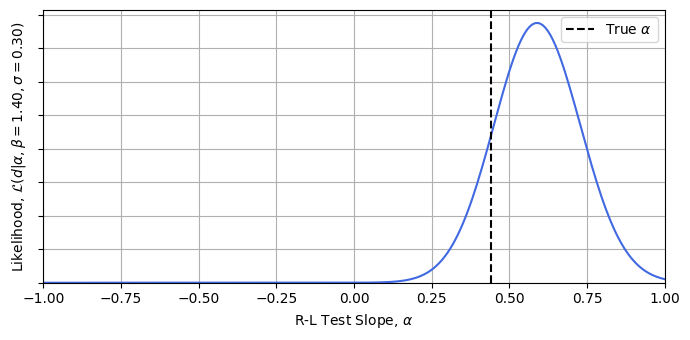

In [11]:
# REDACT
plt.figure(figsize=(7,3.5))
plt.plot(alpha_tests, alpha_likelihood, color = 'royalblue')
plt.axvline(alpha, label = "True $\\alpha$", c='k', ls='--')
plt.xlabel("R-L Test Slope, $\\alpha$")
plt.ylabel("Likelihood, $\mathcal{L}(d \\vert  \\alpha, \\beta=%.2f, \\sigma=%.2f)$" %(beta_test, sig_test))
plt.gca().set_yticklabels([])
plt.grid()
plt.xlim(alpha_tests.min(), alpha_tests.max())
plt.ylim(ymin=0)
plt.gcf().tight_layout()
plt.legend()
plt.show()




## Danger Modes & Their Solutions
Importance sampling might be a crude tool, but that doesn't mean that it's free of subtle failure modes. There are two basic ways you can break importance sampling: either sampling so tightly that you fail to map the full breadth  of the distribution, or either sampling too coarsely to map the fine details of the target distribution. 

### Missing the Tails (Over-Concentration / Misalignment)

The easiest way to mess up importance sampling is to use a sampling distribution that isn't wide enough to properly map out the target distribution. If $P_S(\theta)$ is narrower than $P_T(\theta)$ then our re-weighting over-stresses samples at the wings and becomes unstable. Formally, we can say that the importance ratio must decrease as we go to low sample density:

$$
\frac{P_T(\theta) }{P_S(\theta) }\rightarrow 0\;\; \mathrm{as}\;\; P_S(\theta)\rightarrow0 
$$

If this _isn't_ the case, we 're-weight' to the fringes of the distribution where everything is poorly conditioned. We need the importance of each sample to _decrease_ as we go out to the wings of our samples.


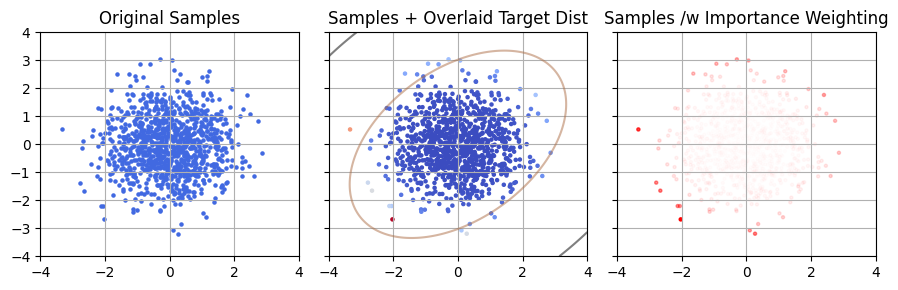

In [12]:
# REDACT
N = 1_000
pos = np.random.multivariate_normal(mean=[0,0], cov = np.eye(2), size=N)

Xs, Ys = pos.T
r1,r2  = .25, .1
cov2 = np.array([[r1+r2,r1-r2],[r1-r2,r1+r2]]) * 32
cov2i = np.linalg.inv(cov2)

Xtest,Ytest = np.random.multivariate_normal(mean=[0,0], cov = cov2, size=N).T

P1 = np.exp(-1/2*(Xs**2+Ys**2)) / np.sqrt(2*np.pi)
p1  = lambda X,Y: np.exp(-0.5*(X**2 * cov2i[0,0] + Y**2) )
p2  = lambda X,Y: np.exp(-0.5*(X**2 * cov2i[0,0] + Y**2 * cov2i[1,1] + X*Y * (cov2i[1,0] + cov2i[0,1])))
P2 = p2(Xs,Ys)
Xgrid, Ygrid = np.meshgrid(*[np.linspace(-4,4,256)]*2)
Pgrid = p2(Xgrid,Ygrid)

R = P2/P1
W = R/R.sum()

I = np.random.choice(range(N), N, replace=True, p=W)

#------------------------------
fig, axs = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
a1,a2,a3 = axs
a1.scatter(Xs, Ys, s = 5, c='royalblue')
a2.scatter(Xs, Ys, s = 5, c = R, cmap = 'coolwarm')
a2.contour(Xgrid, Ygrid, Pgrid, levels = [np.exp(-i**2/2) for i in range(3)][::-1], alpha=0.5, cmap = 'copper')
a3.scatter(Xs, Ys, s = 5, c = 'red', alpha = W/W.max())

for ax in axs: ax.grid()

a1.set_title('Original Samples')
a2.set_title('Samples + Overlaid Target Dist')
a3.set_title('Samples /w Importance Weighting')

plt.tight_layout()
plt.show()


 In the example above, we can see the failure of the weighting visually, but we can't always gauge things by eye in higher dimensions. Another way to frame the problem is to say that $P_S(\theta)$ has to drop _slower_ than $P_T(\theta)$. One way to diagnose this is to plot the two against one another and see if, as we trend to low density (LHS of the plot), whether we trend above (unstable) or below (stable) the $1:1$ line of stability. Doing this below, we can see that the sample density drops too quickly compared to the target density, and so this importance sampling is numerically unstable:


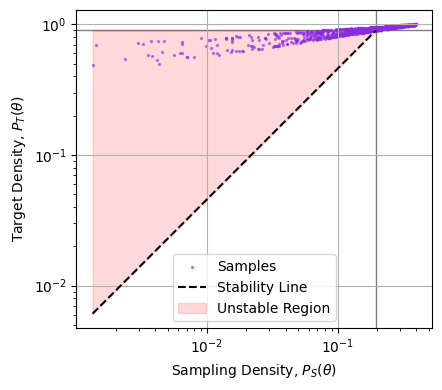

In [13]:
# REDACT
plt.figure(figsize=(8,4))
plt.scatter(P1, P2, s=2, label = 'Samples', alpha=0.5, color = 'blueviolet')
logplot = np.linspace(P1.min(), P1.mean(), 128)
for P, F in zip([P2, P1], [plt.axhline, plt.axvline]): F(P.mean(), lw=1, c='k', zorder=-1, alpha=0.5)
plt.plot(logplot,logplot*P2.mean()/P1.mean(), ls='--', label = 'Stability Line', c='k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Sampling Density, $P_S(\\theta)$")
plt.ylabel("Target Density, $P_T(\\theta)$")

plt.fill_between(logplot, logplot*P2.mean()/P1.mean(), P2.mean(), color='r', alpha=0.15, zorder=-np.inf, label = "Unstable Region")

plt.gca().set_aspect('equal')
plt.grid()
plt.legend()
plt.gcf().tight_layout()
plt.show()

Note that it's only the _slope_ of the cloud as we go to the left that matters, we don't particularly care if a few samples at high density are strongly weighted, only that the importance ratio trends to zero as the sampling thins out.

How to we fix this? Unfortunately there's no immediate cure, we just need to find a way to get a better sample distribution. If our sample distribution is analytical we can just alter it to purpose: widen our gaussians, flatten our power laws etc. If it's stochastic, like a chain of posterior samples, our options are more limited. The only real solution is to use some sort of density estimate (e.g. a kernel density estimator) to turn our sample chain into a closed form density and then defer back to our existing bag of tricks.

### Missing the Peaks (Under-Concentration)
A less common failure mode is when the targeting distribution is _too_ vague. In some cases, the new prior we want to work with will have sharp features, and if our test samples are too sparse they won't sample these spikes and will fail to map them out. Let's consider a real-world example: localization of gravitational waves. Gravitational wave mergers have some $15$ parameters, only three of which have to do with localization. Typically the priors for single source fit assume vague priors for the position: uniform in co-moving distance and in on-sky angular position. However, another approach is to say "GW events probably come from galaxies, so we can use galaxy positions as a prior", the so called "catalogue method" (one program for generating these priors is Rachel Gray's `gwcosmo`, which you can read up on [here](https://arxiv.org/abs/2308.02281)). 

In this case, we can run something like `bilby` to get posterior samples for all the parameters, including the localization. At first glance this sounds like a perfect time to use importance sampling: we're just swapping out a prior from the vague prior $P(\theta \vert \varnothing)$ to a catalogue based one $P(\theta \vert \mathcal{C})$. These samples map the old distribution (left), and we want instead to get a picture of the new distribution (right) with its spikey features <sup>*</sup>.

<sup>*</sup> _This is a rough demonstrative example, so the units and posterior shapes here are arbitrary_  


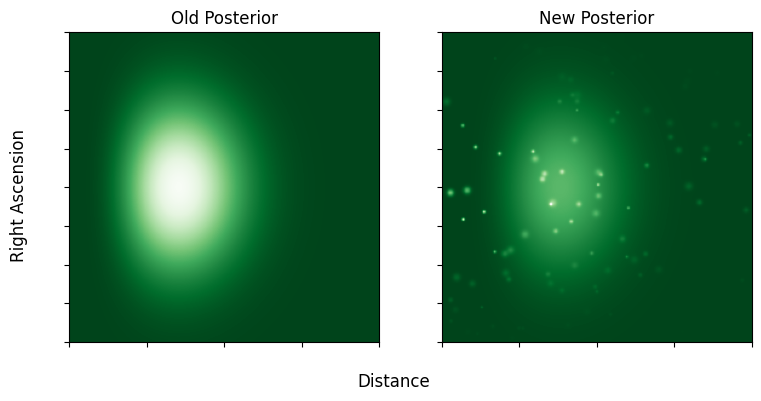

In [14]:
# REDACT
np.random.seed(2)
Nspot = 100
Xspot, Yspot, SIGspot = [np.random.rand(Nspot) * b + a for a,b in zip([0,0,.01], [4,4,0.025])]

def prior_old(X,Y):
    out =  np.exp(-((X)**2+(Y-2)**2))
    out *= X**4
    return out
def prior_new(X,Y):
    out1 = prior_old(X,Y)
    out2 = np.zeros_like(out1)
    for x,y,sig in zip(Xspot,Yspot,SIGspot):
        out2+=np.exp(-0.5*((X-x)**2+(Y-y)**2)/sig**2) / np.sqrt(2*np.pi*sig**2)
    complet = np.exp(-X/2)
    out = out2*complet*np.exp(-(Y-2)**2) + out1*(1-complet)*40
    return out
Xgrid,Ygrid = np.meshgrid(*[np.linspace(0,4,256)]*2)


#--------------------------
fig, [a1,a2] = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))

cmap='Greens_r'
a1.imshow(prior_old(Xgrid,Ygrid), origin='lower', extent = [Xgrid.min(), Xgrid.max(), Ygrid.min(), Ygrid.max()], cmap = cmap)
a2.imshow(prior_new(Xgrid,Ygrid), origin='lower', extent = [Xgrid.min(), Xgrid.max(), Ygrid.min(), Ygrid.max()], cmap = cmap)
a1.set_title("Old Posterior")
a2.set_title("New Posterior")

for a in [a1,a2]:
    a.set_xticklabels([])
    a.set_yticklabels([])
fig.tight_layout()
plt.gcf().supylabel("Right Ascension")
plt.gcf().supxlabel("Distance")
plt.gcf().tight_layout()
plt.show()

So what's the issue? Simple: the little spikes posterior spikes from the galaxies are much narrower than the spacing between test samples. Only a scant handful of the galaxy spikes are sampled at all, and the few that are have barely any samples in them and are subject to shot noise.


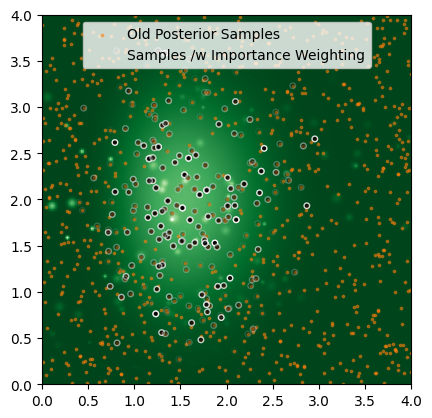

In [15]:
# REDACT
Nscat = 1_000
Xscat, Yscat = np.random.uniform(0,4,Nscat), np.random.uniform(0,4,Nscat)
w = prior_new(Xscat, Yscat)
w/=w.sum()
I = np.random.choice(range(Nscat), Nscat, replace=True, p=w)
plt.imshow(prior_new(Xgrid,Ygrid), origin='lower', extent = [Xgrid.min(), Xgrid.max(), Ygrid.min(), Ygrid.max()], cmap = 'Greens_r')
plt.scatter(Xscat, Yscat, s=3, c='tab:orange', alpha=0.5, label = "Old Posterior Samples")
plt.scatter(Xscat[I], Yscat[I], s=16, edgecolor=['white']*Nscat, alpha=w/w.max(), label = "Samples /w Importance Weighting", facecolor=['none']*Nscat)

plt.legend()
plt.show()

**The Marginalization Trick**

So all is lost, right? No. First, let's formalize the problem. We'll split the paramters into two groups: localization parameters $\eta$ and _non_-localization parameters $\phi$:

$$
\theta \rightarrow \{\phi, \eta\}
$$

We're in a bit of a jam here: we'd like to use importance sampling for _some_ of the parameters, but use some _other_ distribution for the localizations. i.e. we'd:
1. Take $\{\phi_j\}$ from our posterior samples
2. For each of these, replace $\{\eta_j\}$ with an $\eta$ from some other source
Meaning our distributions look like:
$$
P_S(\phi) \sim P( \phi \vert \varnothing), \;\; P_S(\eta) \sim \mathrm{Something\ Else}
$$

There's just one problem: if we start mixing and matching parameters from different distribution we no longer have an easy estimate of the sampling distribution density. Because we're now drawing "posterior $\phi$ at any given $\eta$", and then "$\eta$ from another distribution", we end up with a seperable distribution where the density in $\phi$ has an integral over positions. We've "marginalized out" the dependence on $\eta$:

$$
P_S(\phi, \eta) = P(\phi \vert \varnothing) \times P_S(\eta) = \int P(\phi,\eta \vert \varnothing)d\eta  \times P_S(\eta)
$$

Obviously, it's not exactly trivial to get that integral at any given $\phi$, but nor is it impossible. Because $\eta$ has small dimensionality, it's entirely possible for us to get the integral for every sample in our chain from quadrature or nested sampling. With this re-weighting, we can apply importance sampling per normal. This is a niche trick, but an important tool to keep in your back pocket for the rare edge cases where you need it.

## Why You Should Never Subsample your Nested Samples
Importance sampling can seem a bit niche, it's not every day that we need to use surrogate sampling distributions or re-cycle posterior chains, but the lessons it teaches us apply in a surprisingly broad set of sampling fields. For example, blind prior sampling is really just importance sampling where the contrast comes from the likelihood:

$$
\mathcal{R(\theta)} = \frac{P(\theta \vert d)}{\pi(\theta)} = \frac{\mathcal{L}(d \vert \theta)\pi(\theta)}{\pi(\theta)} = \mathcal{L}(d \vert \theta)
$$

Similarly, nested sampling can be framed as an importance sampling problem as well. If you're not familiar with the particulars of nested sampling, I've got an introductory [blog entry](https://hughmcdougall.github.io/blog/03_stats/01_nestedsampling/page.html) here you might find helpful. In brief: nested sampling generates an ordered sequence of "nested samples" that slowly crawl upwards in posterior density, with each sample $\theta_{\mathrm{NS},i}$ coming with an estimate of the posterior volume "uphill" of it, i.e. the volume of the region with $P(\theta \vert d) \ge P(\theta_{\mathrm{NS},i} \vert d)$. This lets us break the posterior into nested volume "shells" $\{\Delta V_i\}$, each of which we know the density for and consequently their contribution to the evidence:

$$
Z \approx \sum_i \Delta Z_i, \;\ \Delta Z_i = \Delta V_i\times\mathcal{L}(d \vert \theta_{\mathrm{NS},i}) \pi(\theta_{\mathrm{NS},i})
$$

Another of the takeaways of nested sampling is that you can take its nested samples and transform them into a (sightly crunchy) set of posterior samples by weighted redraws with weights $w_i = \Delta Z_i  / Z$. This is, in effect, importance sampling. Each nested sample "owns" a region of parameter space with volume $\Delta V_i$, in which the samples have a density "one sample per volume $\Delta V_i$":

$$
P_{S,\mathrm{NS}}(\theta_\mathrm{NS,i})\approx \frac{1}{\Delta V_i}
$$

Why is this useful to know? It means we can re-use all our intuition about importance sampling, including its virtues and failure modes, for generalized nested sampling. In this example I'm going to fit the same multimodal probability function from my nested sampling tutorial, but using the popular nested sampler [`dynesty`](https://dynesty.readthedocs.io/en/v2.1.5/), and re-using some of the code from their [docs examples](https://dynesty.readthedocs.io/en/stable/dynamic.html). First, run a fit on the target distribution with nested sampling:


In [16]:
from numpy import linalg
import dynesty

def prob_func(x,y):  
    # Two gaussian modes  
    out=0  
    out+=np.exp(-(x - 2)**2-y**2)
    out+=np.exp(-(x + 2)**2-y**2)
    return(np.log(out))

def loglike(x):
    return prob_func(*x)

# Define our uniform prior via the prior transform.
def ptform(u):
    return 20. * u - 10.

# Sample from our distribution.
sampler = dynesty.NestedSampler(loglike, ptform, ndim=2,
                                bound='single', nlive=1_000)
sampler.run_nested(dlogz=0.01, print_progress = False)
res = sampler.results

#-----------
# NS run outputs
Xns, Yns = res.samples.T
logwt = res.logwt

# Resampling to posterior samples
w_norm = np.exp(logwt-logwt.max())
w_norm/=w_norm.sum()
Instopos = np.random.choice(range(len(Xns)), len(Xns), replace=True, p = w_norm)
Xpos, Ypos = Xns[Instopos], Yns[Instopos] # These are posterior distributed


This gives us a series of nested samples and weights for converting to posterior samples. Now suppose I've got some other distribution we want to use these samples to integrate or explore. I'm framing this as a question of going to a target distribution, but remember that this really applies to any target function in general. In this case, I've deliberately chosen a target distribution that _doesn't_ align with the dual guassians of the sample distribution: a unit gaussian centered above them along the x-axis:


In [17]:
mu = np.array([0.0,2.0])
def target_dist(x):
    dx = x-mu[:,None]
    return -0.5 * np.square(dx).sum(axis=0) - 1/2*np.log(2*np.pi)


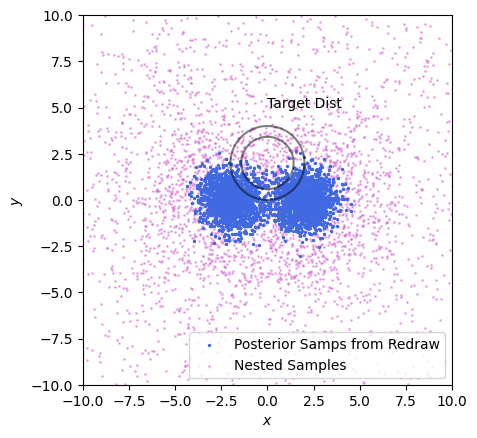

In [18]:
# REDACT

plt.scatter(Xpos, Ypos, s=2, label = "Posterior Samps from Redraw", color = 'royalblue')
plt.scatter(Xns, Yns, alpha = .5, s=1, zorder=-1, label = "Nested Samples", color = 'orchid')

Xgrid, Ygrid = np.meshgrid(*[np.linspace(-10,10,1024)]*2)
Zgrid = np.exp(target_dist(np.vstack([Xgrid.flatten(),Ygrid.flatten()])).reshape(1024,1024))
plt.contour(Xgrid,Ygrid,Zgrid, levels = [np.exp(-2)*Zgrid.max(), np.exp(-1)*Zgrid.max()], alpha=0.5, colors = 'k')
plt.text(0,5,"Target Dist")

plt.axis('square')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

At this stage we've got two options. The most common approach is break this into two steps: converting the nested samples into posterior samples and _then_ doing the importance sampling / taking the integral. This has a lot of intuitive value: posterior samples are easy to understand and work with, and it's the approach taken by groups like LIGO in [publishing results](https://gwosc.org/eventapi/html/allevents/), but as we've seen earlier this is a wasteful approach. Going from nested samples to posterior samples with redraws necessarily throws away information about the wings of the posterior. Instead, it's much better to importance sample the nested samples _directly_.

Taking our results from above, there's two importance ratios, one based on the ratio of the target distribution (`W` in the snippet below) to the original posterior (`prob_func(Xns,Yns)`) and the nested sample densities (`-res.logvol`). Immediately we can see one issue: proper sampling increases the effective sample size by an enormous margin: 

In [19]:
W = target_dist(res.samples.T)
R1 = (W - prob_func(Xns,Yns))[Instopos] # Importance Log-Ratio for posterior->Targ
R2 = W + res.logvol # Importance Log-Ratio for NS->Targ

ESS1, ESS2 = [np.exp(R).sum()**2/(np.exp(R)**2).sum() for R in [R1,R2]]

print("ESS for Posterior Samples is ~%i" %ESS1)
print("ESS for NS Directly is ~%i" %ESS2)

ESS for Posterior Samples is ~70
ESS for NS Directly is ~340



But this is really only the start of the problems with using posterior samples. See in the example below: we only have a few posterior samples that map the target distribution, but even worse they barely scrape a single side of the target. They offer terrible _support_ to the thing we're trying to explore.


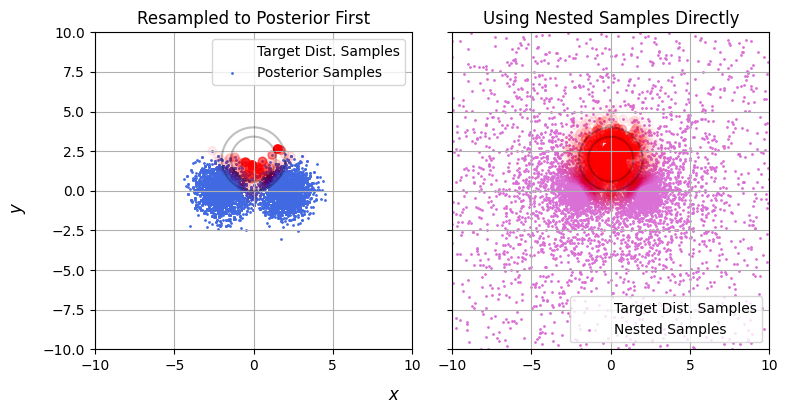

In [20]:
# REDACT
fig, (a1,a2) = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

a1.scatter(Xpos, Ypos, alpha = np.exp(R1-R1.max()), label = 'Target Dist. Samples', color = 'red')
a1.scatter(Xpos, Ypos, zorder=-1, s=1, label = 'Posterior Samples', color = 'royalblue')

a2.scatter(Xns, Yns, alpha = np.exp(R2-R2.max()), label = 'Target Dist. Samples', color = 'red')
a2.scatter(Xns, Yns, zorder=-1, s=1, label = 'Nested Samples', color = 'orchid')
for ax in [a1, a2]: 
    ax.grid()
    ax.contour(Xgrid,Ygrid,Zgrid, levels = [np.exp(-2)*Zgrid.max(), np.exp(-1)*Zgrid.max()], alpha=0.25, colors = 'k')
    ax.set_aspect('equal')
    ax.legend()

a1.set_title("Resampled to Posterior First")
a2.set_title("Using Nested Samples Directly")
fig.supxlabel('$x$')
fig.supylabel('$y$')
fig.tight_layout()

We can quantity this by using some more of the tricks we learned earlier: plotting the stability line. Let's see how the sample and target densities compare between our two methods (below). Nested samples drop off _exponentially_ as we go away from the peaks, while the target distribution drops off like a gaussian (exponential _squared_), and so the samples rapidly peel downwards from the unstable region. Put simply: nested samples explore the _entire_ domain, even when seeking a particular posterior. By contrast, the posterior samples are very _un_-stable, as they only barely cover the target and so have the entire upper half sparsely explored.

What's the take away here? Simple: if you fit with nested sampling, **don't subsample**. If you want to do anything more complicated than plotting a corner plot, this is asking for numerical instability and destroys information that you might need later and for zero benefit. Instead, retain the nested samples along with their weights, and leverage the full set of data.



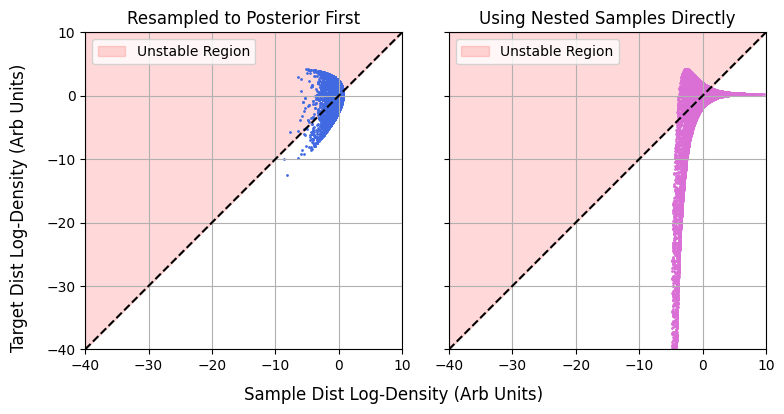

In [21]:
# REDACT
fig, (a1,a2) = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)

a1.scatter(prob_func(Xns,Yns)[Instopos]-np.median(prob_func(Xns,Yns)[Instopos]), W[Instopos]-np.median(W), s=1, color='royalblue')
a2.scatter(-(res.logvol-np.median(res.logvol)), W-np.median(W), s = 1, color = 'orchid')

a1.set_title("Resampled to Posterior First")
a2.set_title("Using Nested Samples Directly")

lineplot = np.linspace(-40,10,128)
for a in a1,a2: 
    a.axline((0,0),slope=1, ls='--', c='k')
    a.set_xlim(-40,10)
    a.set_ylim(-40,10)
    a.set_aspect('equal')
    a.fill_between(lineplot, lineplot, 10, color='r', alpha=0.15, zorder=-np.inf, label = "Unstable Region")
    a.grid()
    a.legend()
fig.supxlabel("Sample Dist Log-Density (Arb Units)")
fig.supylabel("Target Dist Log-Density (Arb Units)")
fig.tight_layout()
plt.show()

What does this actually do to our answers? Suppose we were trying to integrate the target distribution. Using both methods we get the same answer _on average_, they're unbiased by their derivations. Where they differ is in their _variance_. If we run the fitting process a few hundred times for both methods, we can see that the direct nested sampling method has a _much_ tighter spread (bottom panel), while the seemingly small step of subsampling to the posterior completely blows out the tails of the distribution (top panel).


In [ ]:
# REDACT
# Sample from our distribution.
def run(N_sub):
    
    sampler = dynesty.NestedSampler(loglike, ptform, ndim=2,
                                bound='single', nlive=200
                                   )

    sampler.run_nested(dlogz=0.01, print_progress=False)
    res = sampler.results
    
    #-----------
    # NS run outputs
    Xns, Yns = res.samples.T
    logwt = res.logwt
    
    # Resampling to posterior samples
    w_norm = np.exp(logwt-logwt.max())
    w_norm/=w_norm.sum()
    R1s = np.zeros(N_sub)
    W = target_dist(res.samples.T)
    for i in range(N_sub):
        Instopos = np.random.choice(range(len(Xns)), len(Xns), replace=True, p = w_norm)
        R1 = (W - prob_func(Xns,Yns)+res.logz[-1])[Instopos] # Importance Log-Ratio for posterior->Targ
        R1s[i] = np.exp(R1).mean()
        
    R2 = W + res.logvol # Importance Log-Ratio for NS->Targ
    W = target_dist(res.samples.T)

    return(R1s, np.exp(R2).mean())

out1, out2 = [],[]
from multiprocessing import Pool
for i in range(200):
    a, b = run(100)
    out1.append(a)
    out2.append(b)
out1 = np.concatenate(out1)
out2 = np.array(out2)

In [ ]:
# REDACT
fig, (a1,a2) = plt.subplots(2,1, figsize=(8,4), sharex=True, sharey=False)
fac = 1/2/np.sqrt(2)/np.pi
volfac = 20**2/.94

a1.hist(out1*volfac, alpha=0.5, density=True, bins=128, color = 'royalblue', label = "Resample to Posterior First", range = (0,8))
a2.hist(out2/fac*volfac, alpha=0.5, density=True, bins=16, color = 'orchid', label = "Use Nested Samples Directly")

a1.axvline(out1.mean()*volfac, color = 'royalblue')
a2.axvline(out2.mean()/fac*volfac, color = 'orchid')

for a in [a1,a2]: 
    a.set_yticks([])
    a.grid()
    a.set_xlim(xmin=0, xmax=8)
    a.axvline((Zgrid.sum() * np.ptp(Xgrid) * np.ptp(Ygrid) / (1024**2)), ls='--', label = "Truth", c='k', zorder=-1)
    a.legend()
fig.supxlabel("Est. Target Integral")
fig.supylabel("Density over Many Itterations")
fig.tight_layout()
plt.show()

## Conclusion
Importance sampling might not be the most advanced of our statistical tools, but its logical underpinnings thread through the entire span of numerical bayesian statistics. It's a tool we can't afford to ignore for the edge cases where it is the only viable option, but maybe more importantly it's a tool we can't afford to _misunderstand_, as its DNA, including its failure modes, is inherited by dozens of fancier and more fashionable methods. 


----

## A Fun Appendix: Importance Sampling with ELBO & EUBO

Up above I talk about how importance sampling can be used to estimate evidences: taking samples from a sampling / proposal distribution and seeing how much they differ from the target distribution "on average". If you're familiar with Stochastic Variational Inference (SVI) <sup>*</sup>, this might have some nagging familiarity. For brevity define some importance ratio $\mathcal{R}\left(\theta\right)=\frac{\rho_M\left(\theta\right)}{P_S\left(\theta\right)}$. From what we saw above, we know that our best (i.e. _unbiased_ estimate of $Z_m$ comes from the expected value of $\mathcal{R}(\theta)$, i.e. "the average ratio of the distributions":

$$
Z_M = E_S \left[ \mathcal{R}(\theta)\right]
$$

It looks very similar to SVI's **Evidence Lower Bound** ($\mathrm{ELBO}$), which takes the same average over _log_ ratio, and gives a _minimum_ estimate of the evidence:

$$
\ln \left| Z_m \right| \ge \mathrm{ELBO} = \mathrm{KL}_{S \rightarrow M} = E_S \left[ \ln \left| \mathcal{R}(\theta)\right| \right]
$$

Here $\mathrm{KL}_{S \rightarrow M}$ is the [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the sampling and target distributions, a measure of how different they are. The core idea of SVI is to have some parameter $P_S (\theta)$ and tweak those parameters to get the ELBO as low as possible, and because of the one-sided inequality as close to the actual evidence as possible. 

A slightly less known cousin to the $\mathrm{ELBO}$ is the **evidence _upper_ bound**, the $\mathrm{EUBO}$. This can be derived pretty directly from symmetry. If the KL divergence from $S \rightarrow M$ puts a lower bound on $Z_m$, the inverse distance KLD from $M \rightarrow S$ should put a lower bond on the inverse evidence:

$$
\ln \left| \frac{1}{Z_m} \right| \ge \mathrm{KL}_{M \rightarrow S} = E_M \left[\ln \left| \frac{1}{\mathcal{R}(\theta)} \right| \right]
$$

We can't take an expected value over $\theta \sim M$ directly, but importance sampling lets us do it over $\theta \sim S$:

$$
\ln \left| Z_m \right| \le \mathrm{EUBO} = E_S \left[ \frac{-\mathcal{R}(\theta)}{E_S \left[ \mathcal{R}(\theta) \right]} \ln \left| \mathcal{R}(\theta) \right| \right]
$$

What's neat about all of this is that none of these estimators require new calculations. We still have $\{\mathcal{R}(\theta_i)\}$ from estimating $Z_M$, and so we can also gets bounds on this number for free:

$$
Z_M \approx E_S\left[\mathcal{R}\left(\theta\right)\right],\ \ \ln{\left|Z_M\right|}\in\left[E_S\left[\ln{\left|\mathcal{R}\left(\theta\right)\right|}\right],\ \ \frac{1}{E_S\left[\mathcal{R}\left(\theta\right)\right]}E_S\left[-\mathcal{R}\left(\theta\right)\ln{\left|\mathcal{R}\left(\theta\right)\right|}\right]\right]
$$

<sup>*</sup> _If you're not familiar with SVI, I have introductory writeup [here](https://hughmcdougall.github.io/blog/02_numpyro/06_SVI/01_part1/page.html)_